In [2]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

Neural Network Model for Hyper Parameter Tuning

In [3]:
def branin(X, Y):
    a = 1.0
    b = 5.1 / (4.0 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8.0 * np.pi)
    
    return a * (Y - b * X**2 + c * X - r)**2 + s * (1 - t) * np.cos(X) + s


In [4]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [5]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, a, b: 0.1*(a - 4) * x + 0.05*(b + 3) * x**2 + r.normal(0, sim_stdev)

In [6]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 10, 10)
Y = np.random.uniform(0, 15, 10)

# Calculate the outputs using Branin and Currin functions
output1 = branin(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [7]:
sim_eval = lambda x, y, a, b: branin(x, y) + sim_err(x, a, b)

In [8]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (2,5)},
          {'name': 'b', 'type': 'continuous', 'domain': (-4,-1)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 3.95963037 -3.00534208]


In [9]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


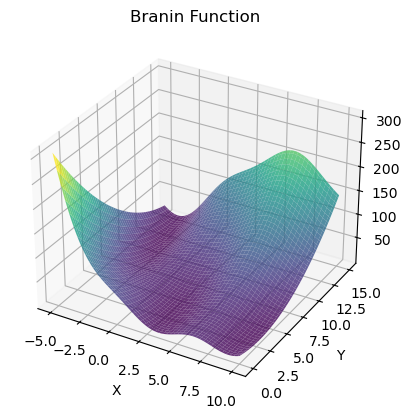

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 10, 100)
y_range = np.linspace(0, 15, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = branin(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Branin Function')

# Show the plot
plt.show()

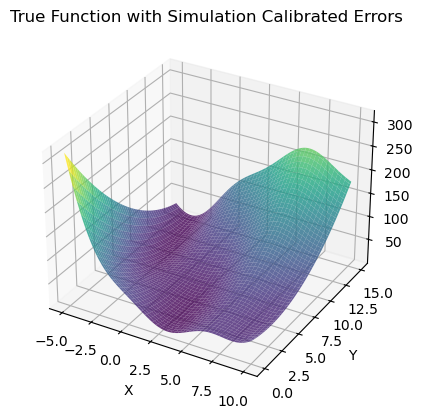

In [11]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[0])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [12]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=100):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [13]:
def perform_iteration(df):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-5, 10, 100)
    x2_range  = np.linspace(0, 15, 100)

    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # Perform MC Dropout predictions for entire meshgrid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

    # Identify top 10 points with highest uncertainty
    num_new_points = 10
    high_uncertainty_indices = np.argsort(pred_std)[-num_new_points:]
    new_points = x_grid[high_uncertainty_indices]

    # Store new simualted points to validate and sample
    new_points_df = pd.DataFrame(new_points, columns=['x', 'y'])

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + 1.96 * pred_std).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - 1.96 * pred_std).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot the high uncertainty points
    ax.scatter(new_points[:, 0], new_points[:, 1], color='black', marker='o', label='High Uncertainty Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    # Add validated data points to original data frame
    new_points_df["z"] = branin(new_points_df['x'], new_points_df['y']) + ran_err(num_new_points, 0.05)
    new_points_df["a"] = bo.x_opt[0]
    new_points_df["b"] = bo.x_opt[1]
    new_points_df["sim_z"] = sim_eval(new_points_df["x"], new_points_df["y"], new_points_df["a"], new_points_df["b"])
    new_points_df["diff"] = new_points_df["z"] - new_points_df["sim_z"]

    df = pd.concat([df, new_points_df], axis=0, ignore_index=True)
    return df


Best hyperparameters:
num_layers: 7
num_units: 199
learning_rate: 0.0021252073916553185
dropout_rate: 0.20718429411318445
batch_size: 82
epochs: 144
Epoch 1/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 7627.3413
Epoch 2/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7605.7515
Epoch 3/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7560.7954
Epoch 4/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7463.7056
Epoch 5/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7249.7593
Epoch 6/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6937.8594
Epoch 7/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6104.4683
Epoch 8/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5057.1982
Epoch 9/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3985.5540
Epoch 10/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3068.1890
Epoch 11/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2546.9482
Epoch 12/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3490.0144
Epoch 13/144
1/1 ━━━━━━━━━━━━━━━━━

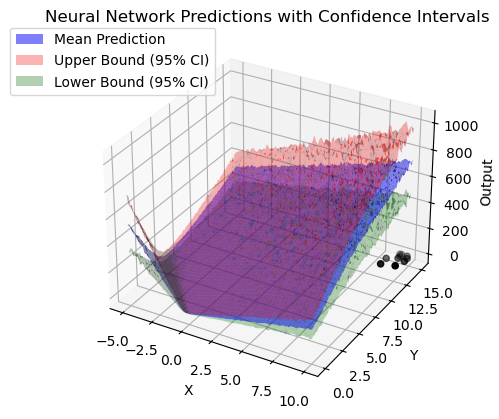

In [14]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.1
dropout_rate: 0.020634240457265054
batch_size: 150
epochs: 50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step - loss: 13943.9512
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8483.5049
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7279.9907
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5278.9424
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2628.1965
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5329.6587
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5983.2441
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4612.3237
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2465.7593
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2590.7429
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3673.4429
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2069.4348
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1

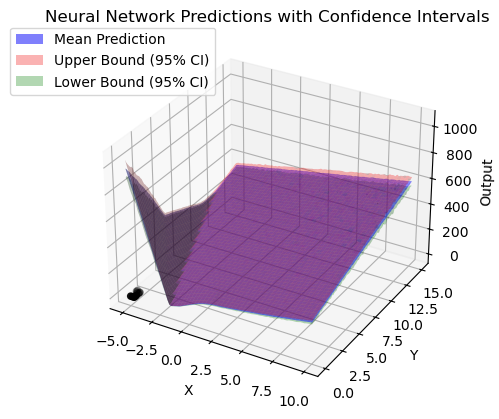

In [15]:
df = perform_iteration(df)

In [16]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


Best hyperparameters:
num_layers: 7
num_units: 199
learning_rate: 0.0021252073916553185
dropout_rate: 0.20718429411318445
batch_size: 82
epochs: 144
Epoch 1/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 34710.3086
Epoch 2/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 34658.8125
Epoch 3/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 34549.3633
Epoch 4/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 34346.7305
Epoch 5/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 33814.3281
Epoch 6/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 32930.9414
Epoch 7/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 31189.2715
Epoch 8/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 28746.6992
Epoch 9/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 22625.0625
Epoch 10/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 15117.4023
Epoch 11/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7849.5381
Epoch 12/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11110.7617
Epoch 13/144
1/1 ━━━━━━

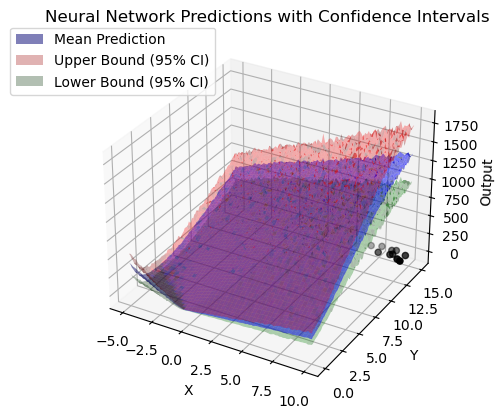

In [17]:
df = perform_iteration(df)

In [18]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


Best hyperparameters:
num_layers: 8
num_units: 137
learning_rate: 0.0014108892283675816
dropout_rate: 0.3793078121611787
batch_size: 34
epochs: 121
Epoch 1/121
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 33244.2578
Epoch 2/121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33192.0820 
Epoch 3/121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32656.6387 
Epoch 4/121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31600.8828 
Epoch 5/121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32618.8262 
Epoch 6/121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29483.8652 
Epoch 7/121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31069.1152 
Epoch 8/121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27105.6348 
Epoch 9/121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21997.7031 
Epoch 10/121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14982.3105 
Epoch 11/121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5493.8369 
Epoch 12/121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12389.7842 
Epoch 13/121
2/2 ━━━━━━

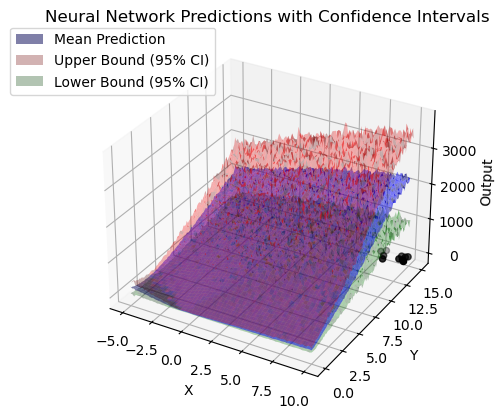

In [19]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 121
learning_rate: 0.1
dropout_rate: 0.5
batch_size: 20
epochs: 190
Epoch 1/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 27258.3789  
Epoch 2/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10344.3262
Epoch 3/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8500.0762 
Epoch 4/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14898.9453 
Epoch 5/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6561.6455 
Epoch 6/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6609.4932 
Epoch 7/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4566.5581 
Epoch 8/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5843.4102 
Epoch 9/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5571.2437 
Epoch 10/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4217.9092 
Epoch 11/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4564.8169 
Epoch 12/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4719.8506 
Epoch 13/190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3366.

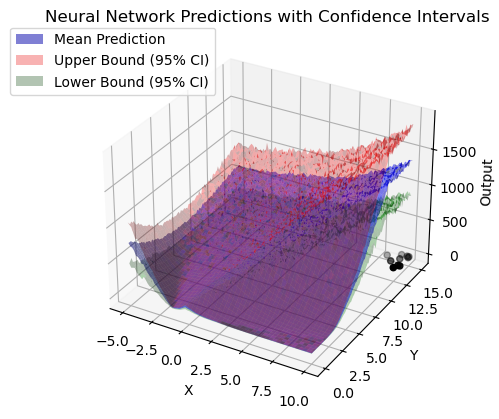

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


In [20]:
df = perform_iteration(df)
df

Best hyperparameters:
num_layers: 4
num_units: 200
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 86
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 28619.4238
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3075386.7500
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 31058.4863
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 28773.4199
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28337.8770
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 26582.1465
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 19636.8125
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7051.4062
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 24950.4180
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11449.0498
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 16921.0859
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9420.9238
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - los

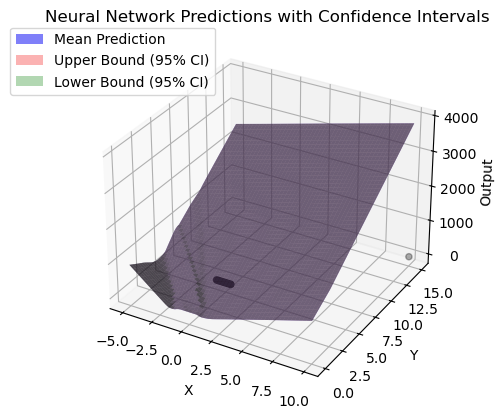

In [22]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 5
num_units: 200
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20667946.0000
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 194088.5312
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52034.6914 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10016.0615 
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4349.3140 
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19756.3828 
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11911.2041 
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7508.6792 
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5913.3027 
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6562.7485 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3130.7747 
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3128.8005 
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

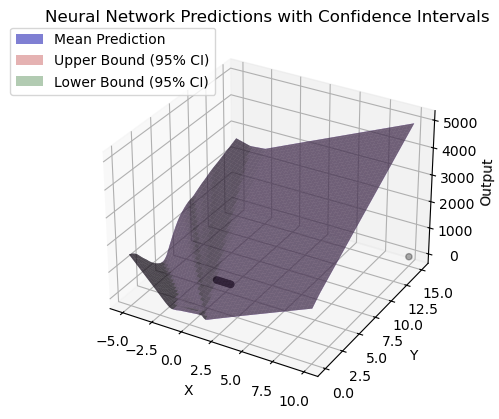

In [23]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.013306161976048982
dropout_rate: 0.0
batch_size: 22
epochs: 172
Epoch 1/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 25743.6152  
Epoch 2/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22713.4941 
Epoch 3/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19107.9121 
Epoch 4/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18075.2402 
Epoch 5/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13667.3311 
Epoch 6/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7610.5806 
Epoch 7/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4268.0229 
Epoch 8/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4255.8760 
Epoch 9/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5281.8521 
Epoch 10/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3881.3782 
Epoch 11/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3500.8403 
Epoch 12/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3591.4412 
Epoch 13/172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

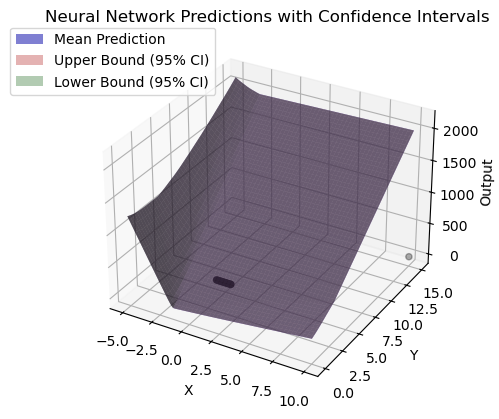

In [24]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 4
num_units: 200
learning_rate: 0.05421050662840743
dropout_rate: 0.28378598854357856
batch_size: 20
epochs: 115
Epoch 1/115
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14225.2012
Epoch 2/115
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18179.8164 
Epoch 3/115
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12804.9023 
Epoch 4/115
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7669.2510 
Epoch 5/115
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6520.6680 
Epoch 6/115
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3096.2456 
Epoch 7/115
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3888.5754 
Epoch 8/115
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3846.5505 
Epoch 9/115
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3593.1975 
Epoch 10/115
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2619.3384 
Epoch 11/115
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1779.6484 
Epoch 12/115
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8799.2275 
Epoch 13/115
5/5 ━━━━━━━━━━━━━━━

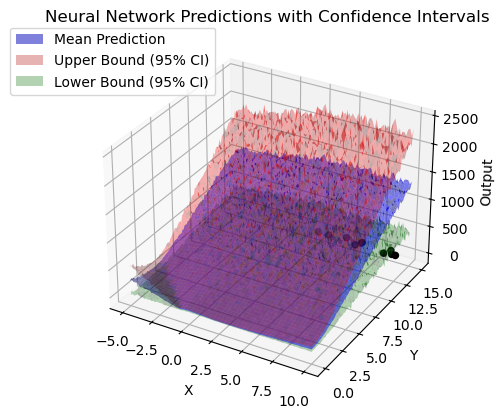

In [26]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 93
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14908.0098  
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7338.1064 
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5546.5537 
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4938.9492 
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3112.5889 
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1517.1840 
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 835.8719 
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 593.3212 
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 704.2274 
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 800.3895 
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 562.8462 
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 595.4495 
Epoch 13/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 459.6806 
Epo

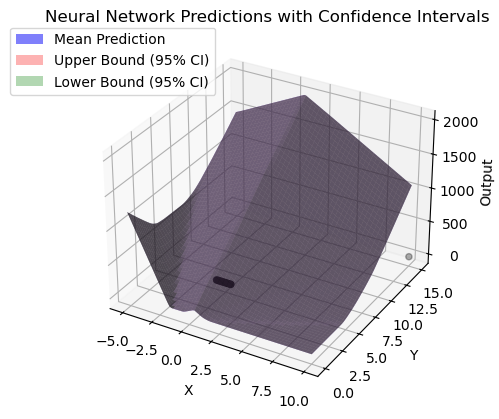

In [27]:
df = perform_iteration(df)

In [28]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
...,...,...,...,...,...,...,...
105,0.151515,5.000000,20.038478,3.95963,-3.005342,20.066803,-0.028325
106,0.303030,5.000000,19.430313,3.95963,-3.005342,19.438751,-0.008439
107,0.454545,5.000000,18.722536,3.95963,-3.005342,18.712139,0.010397
108,-0.606061,5.000000,22.016555,3.95963,-3.005342,21.937501,0.079054


Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step - loss: 19436.6680
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 12782.4785
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4686.1460
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5198.0044
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3924.5454
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4541.5317
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3046.0029
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2890.9312
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2262.2339
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1891.8074
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1693.1847
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1038.1256
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 104

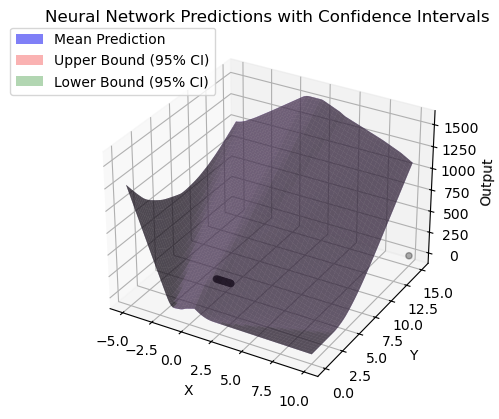

In [29]:
df = perform_iteration(df)